In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, matthews_corrcoef, roc_auc_score, confusion_matrix, f1_score, classification_report, recall_score, roc_curve

import optuna

import psycopg2
from config import *

from datetime import timedelta

import utm
import time

import glob

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.utils import class_weight
import optuna

import seaborn as sns

In [20]:
conexion = psycopg2.connect(database=db_database, 
                                user=db_user, 
                                password=db_password, 
                                host=db_host, 
                                port=db_port)

In [21]:
fechaHasta='2023-01-01'
pathModelos = '/data/proyectos/GRAPEVINE/Models/fjlacueva/Phenology/RandomForests'
query="select * from public.sabana_sin_rad where fecha <= '"+ fechaHasta + "';"
sabana = pd.read_sql_query(query, con=conexion).drop_duplicates()
sabana

,phenologystageid,variedad,codigo,longitude,latitude,altitud,doc_id,fecha,estacion,season,...,do_Borja,do_Calatayud,do_Cariñena,do_Somontano,variedad_CABERNET SAUVIGNON,variedad_CHARDONNAY,variedad_GARNACHA,variedad_MAZUELA,variedad_SYRACH,variedad_TEMPRANILLO
0,10.0,CABERNET SAUVIGNON,50144A02900008,-1.195923,41.401890,506.0,Cariñena,2019-08-16,gv01,2018_2019,...,0,0,1,0,1,0,0,0,0,0
1,10.0,GARNACHA,50144A02300023,-1.176083,41.371589,580.0,Cariñena,2019-08-16,gv01,2018_2019,...,0,0,1,0,0,0,1,0,0,0
2,10.0,SYRACH,50073A08400031,-1.207635,41.355942,565.0,Cariñena,2019-08-16,gv01,2018_2019,...,0,0,1,0,0,0,0,0,1,0
3,10.0,GARNACHA,50073A00500022,-1.208139,41.397524,507.0,Cariñena,2019-08-16,gv01,2018_2019,...,0,0,1,0,0,0,1,0,0,0
4,10.0,MAZUELA,50073A08600010,-1.179190,41.354589,592.0,Cariñena,2019-08-16,gv01,2018_2019,...,0,0,1,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
104630,10.0,CABERNET SAUVIGNON,50144A02900008,-1.195923,41.401890,506.0,Cariñena,2019-08-15,gv01,2018_2019,...,0,0,1,0,1,0,0,0,0,0
104631,10.0,GARNACHA,50144A02300023,-1.176083,41.371589,580.0,Cariñena,2019-08-15,gv01,2018_2019,...,0,0,1,0,0,0,1,0,0,0
104632,10.0,SYRACH,50073A08400031,-1.207635,41.355942,565.0,Cariñena,2019-08-15,gv01,2018_2019,...,0,0,1,0,0,0,0,0,1,0
104633,10.0,GARNACHA,50073A00500022,-1.208139,41.397524,507.0,Cariñena,2019-08-15,gv01,2018_2019,...,0,0,1,0,0,0,1,0,0,0


In [22]:
sabana['doc_id']=sabana.doc_id.fillna('New')

In [23]:
sabana.doc_id.value_counts()

Cariñena     68387
Borja        28918
Calatayud     7141
Somontano      189
Name: doc_id, dtype: int64

In [24]:
parcelas_train=[]
parcelas_test=[]
parcelas_vali=[]
for do in sabana.doc_id.unique():
    print(do)
    parcelas_do_train, parcelas_do_no=train_test_split(list(sabana[sabana.doc_id==do].codigo.unique()),
                                                       random_state=17,test_size=0.4)
    parcelas_train=parcelas_train+parcelas_do_train
    if len(parcelas_do_no)>1:
        parcelas_do_vali, parcelas_do_test=train_test_split(parcelas_do_no,test_size=0.5, random_state=17)
        parcelas_train=parcelas_train+parcelas_do_train
        parcelas_test=parcelas_test+parcelas_do_test
        parcelas_vali=parcelas_vali+parcelas_do_vali
    else:
        pascelas_test=parcelas_test+parcelas_do_no

Cariñena
Borja
Calatayud
Somontano


In [25]:
temp=sabana.copy()
datos_list=[]
for id_terr in temp.codigo.unique():
    datos_camp_terr=temp[temp['codigo']==id_terr]
    datos_camp_terr['next_fecha']=datos_camp_terr['fecha'].shift(-7)
    datos_camp_terr['next_pheno']=datos_camp_terr['phenologystageid'].shift(-7)
    datos_camp_terr=datos_camp_terr[(datos_camp_terr.next_fecha-datos_camp_terr.fecha).dt.days==7]
    datos_list.append(datos_camp_terr)
datos_total=pd.concat(datos_list).reset_index(drop=True)
datos_total

/home/glabata/.conda/envs/grapevine/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/home/glabata/.conda/envs/grapevine/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/glabata/.conda/envs/grapevine/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead


/home/glabata/.conda/envs/grapevine/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/home/glabata/.conda/envs/grapevine/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/glabata/.conda/envs/grapevine/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead


/home/glabata/.conda/envs/grapevine/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/home/glabata/.conda/envs/grapevine/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/glabata/.conda/envs/grapevine/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead


/home/glabata/.conda/envs/grapevine/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/home/glabata/.conda/envs/grapevine/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/glabata/.conda/envs/grapevine/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead


/home/glabata/.conda/envs/grapevine/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/home/glabata/.conda/envs/grapevine/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/glabata/.conda/envs/grapevine/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead


/home/glabata/.conda/envs/grapevine/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/home/glabata/.conda/envs/grapevine/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/glabata/.conda/envs/grapevine/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead


/home/glabata/.conda/envs/grapevine/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/home/glabata/.conda/envs/grapevine/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/glabata/.conda/envs/grapevine/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead


,phenologystageid,variedad,codigo,longitude,latitude,altitud,doc_id,fecha,estacion,season,...,do_Cariñena,do_Somontano,variedad_CABERNET SAUVIGNON,variedad_CHARDONNAY,variedad_GARNACHA,variedad_MAZUELA,variedad_SYRACH,variedad_TEMPRANILLO,next_fecha,next_pheno
0,10.0,CABERNET SAUVIGNON,50144A02900008,-1.195923,41.401890,506.0,Cariñena,2019-08-16,gv01,2018_2019,...,1,0,1,0,0,0,0,0,2019-08-23,10.0
1,10.0,CABERNET SAUVIGNON,50144A02900008,-1.195923,41.401890,506.0,Cariñena,2019-08-17,gv01,2018_2019,...,1,0,1,0,0,0,0,0,2019-08-24,10.0
2,10.0,CABERNET SAUVIGNON,50144A02900008,-1.195923,41.401890,506.0,Cariñena,2019-08-18,gv01,2018_2019,...,1,0,1,0,0,0,0,0,2019-08-25,10.0
3,10.0,CABERNET SAUVIGNON,50144A02900008,-1.195923,41.401890,506.0,Cariñena,2019-08-19,gv01,2018_2019,...,1,0,1,0,0,0,0,0,2019-08-26,10.0
4,10.0,CABERNET SAUVIGNON,50144A02900008,-1.195923,41.401890,506.0,Cariñena,2019-08-20,gv01,2018_2019,...,1,0,1,0,0,0,0,0,2019-08-27,10.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
80452,10.0,GARNACHA,44033A00100095,-1.361989,41.047367,824.0,Calatayud,2022-11-07,Z18,2021_2022,...,0,0,0,0,1,0,0,0,2022-11-14,10.0
80453,10.0,GARNACHA,44033A00100095,-1.361989,41.047367,824.0,Calatayud,2022-11-08,Z18,2021_2022,...,0,0,0,0,1,0,0,0,2022-11-15,10.0
80454,10.0,GARNACHA,44033A00100095,-1.361989,41.047367,824.0,Calatayud,2022-11-09,Z18,2021_2022,...,0,0,0,0,1,0,0,0,2022-11-16,10.0
80455,10.0,GARNACHA,44033A00100095,-1.361989,41.047367,824.0,Calatayud,2022-11-10,Z18,2021_2022,...,0,0,0,0,1,0,0,0,2022-11-17,10.0


In [26]:
conexion.close()

In [27]:
def eval_model(model_chars,train,vali):
    variedades=[col for col in train.columns if 'variedad_' in col]
    dos=[col for col in train.columns if 'do_' in col]
    variables_basic=['phenologystageid','dia', 'min', 'max', 'mean', 'std', 'median','diff']+variedades+dos
    medidas=variables_basic
    
    altitud=model_chars['params_Altitud']
    latitud=model_chars['params_Latitud']
    longitud=model_chars['params_Longitud']
    if(longitud):
        medidas.append('longitude')
    if(latitud):
        medidas.append('latitude')
    if(altitud):
        medidas.append('altitud')
        
    if model_chars['params_Acumuladas']:
        
        inicio=model_chars['params_Inicio mediciones']
        suffix=''
        name_vars=[]
        
        chilling=model_chars['params_Chilling']
        winkler=model_chars['params_Winkler']
        gdd=model_chars['params_gdd']
        
        acumulativo=model_chars['params_Acumulativo']
        if (acumulativo):
            suffix='_Cumm'
            if model_chars['params_Precipitaciones']:
                name_vars.append('precip__'+inicio+'_')
#             if model_chars['params_Radiacion']:
#                 name_vars.append('rad__'+inicio+'_')
                
        if (winkler|gdd):
            tbase=model_chars['params_Tbase']
            temperatura_inicio=str(model_chars['params_Temperatura inicio'])
        if (chilling):
            tbase_chill=model_chars['params_Tbase_chilling']
            name_vars.append('chillingDD_7.0_'+inicio+'_' + tbase_chill +'_sum')
        if (winkler):
            if acumulativo:
                name_vars.append('winkler_'+temperatura_inicio+'_'+inicio+'_' + tbase)
            else:
                name_vars.append('winkler_'+temperatura_inicio+'_' + tbase)
        if (gdd):
            name_vars.append('gdd_'+temperatura_inicio+'_'+inicio+'_' + tbase+'_sum')
       
        if len(name_vars)>0:
            semanas_list=[]
            for i in range(1,3):
                if model_chars['params_'+str(i)+'_semanas_atras']:
                    semanas_list.append(' '+str(i)+'_semanas_atras')
            if model_chars['params_1_semanas_adelante']:
                    semanas_list.append(' 1_semanas_adelante')
                    
            for name_var in name_vars:
                medidas.append(name_var+suffix)
                for semana in semanas_list:
                    medidas.append(name_var+suffix+semana)
        
    else:
        name_vars=[]    
        if model_chars['params_Temperatura']:
            if model_chars['params_Temperatura_media']:
                name_vars.append('tmed_mean')
            if model_chars['params_Temperatura_min']:
                name_vars.append('tmed_min')
            if model_chars['params_Temperatura_max']:
                name_vars.append('tmed_max')

        if model_chars['params_Viento']:
            if model_chars['params_Viento_norte']:
                name_vars.append('wind_N')
            if model_chars['params_Viento_noreste']:
                name_vars.append('wind_NE')
            if model_chars['params_Viento_este']:
                name_vars.append('wind_E')
            if model_chars['params_Viento_sureste']:
                name_vars.append('wind_SE')
            if model_chars['params_Viento_sur']:
                name_vars.append('wind_S')
            if model_chars['params_Viento_suroeste']:
                name_vars.append('wind_SW')
            if model_chars['params_Viento_oeste']:
                name_vars.append('wind_W')
            if model_chars['params_Viento_noroeste']:
                name_vars.append('wind_NW')
        
        if len(name_vars)>0:
            dias_vars=[]
            for i in range(1,14):
                if model_chars['params_'+str(i)+'_dias_atras']:
                    dias_vars.append(' ' + str(i) + '_dias_atras')
            for i in range(1,7):
                if model_chars['params_'+str(i)+'_dias_adelante']:
                    dias_vars.append(' ' + str(i) + '_dias_adelante')

            for name_var in name_vars:
                medidas.append(name_var)
                for dia_var in dias_vars:
                    medidas.append(name_var+dia_var)

    medidas.append('next_pheno')
    
    train=train[medidas].dropna()
    vali=vali[medidas].dropna()             
    
    X_train=train.drop(['next_pheno'], axis=1).values
    Y_train=train['next_pheno'].values
    X_vali=vali.drop(['next_pheno'], axis=1).values
    Y_vali=vali['next_pheno'].values
    
    params = {'random_state':17,'n_jobs':-1,
              'criterion':model_chars['params_criterion'],
              'class_weight':'balanced',
              'max_depth':model_chars['params_max_depth'],
              'min_samples_leaf':model_chars['params_min_samples_leaf'],
              'n_estimators':int(model_chars['params_n_estimators'])}
    
    model=RandomForestClassifier(**params)
    
    model.fit(X_train,Y_train)
    preds=model.predict(X_vali)
    preds_proba=model.predict_proba(X_vali)
    
    mcc=matthews_corrcoef(Y_vali,preds)
    print("MCC: ",mcc)
    print("Accuracy: ", accuracy_score(Y_vali,preds))
#     print("F1-score: ", f1_score(Y_vali,preds))
    print("Confussion matrix:")
    print(confusion_matrix(Y_vali,preds))
    print("Summary:")
    print(classification_report(Y_vali,preds))
    
    cf_matrix=confusion_matrix(vali['next_pheno'],preds)
    cf_matrix=cf_matrix.T/cf_matrix.sum(axis=1)
    
    sns.heatmap(cf_matrix.T, annot=True)
    plt.show()
    
    return model, medidas

In [28]:
train=datos_total[datos_total.codigo.isin(parcelas_train)]
vali=datos_total[datos_total.codigo.isin(parcelas_vali)]
test=datos_total[datos_total.codigo.isin(parcelas_test)]
train=train.drop(columns=['codigo','fecha'])
vali=vali.drop(columns=['codigo','fecha'])
test=test.drop(columns=['codigo','fecha'])

0.8370929659105292
Validation
MCC:  0.8241832298455514
Accuracy:  0.8652347976628435
Confussion matrix:
[[7600    0    0    0    0    0    0    0    0    0    9]
 [   0  820   79    2    0    0    0    0    0    0    0]
 [   0  114  503   35    0    1    0    0    0    0    0]
 [   0    6  465  902  115   45  173    0    0    0    0]
 [   0    0    1   27   73   63  106    6    0    0    0]
 [   0    1   24    3   45   66   57   12    1    0    0]
 [   0    0    0    0   26    7  118    8    5    0    0]
 [   0    0    0    0   33   52  134   78   77    9    0]
 [   0    0    0    0    3    1   69   35  417   89    0]
 [   0    0    0    0    0    0    0    2  199 1396   64]
 [   0    0    0    0    0    0    0    0    0  288 4020]]
Summary:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      7609
         1.0       0.87      0.91      0.89       901
         2.0       0.47      0.77      0.58       653
         3.0       0.93      0.

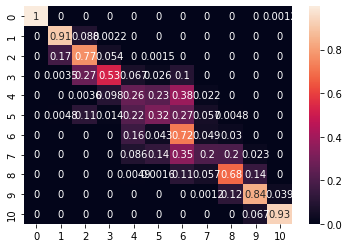

(RandomForestClassifier(class_weight='balanced', max_depth=5,
                        min_samples_leaf=0.05, n_estimators=70, n_jobs=-1,
                        random_state=17),
 ['phenologystageid',
  'dia',
  'min',
  'max',
  'mean',
  'std',
  'median',
  'diff',
  'variedad_CABERNET SAUVIGNON',
  'variedad_CHARDONNAY',
  'variedad_GARNACHA',
  'variedad_MAZUELA',
  'variedad_SYRACH',
  'variedad_TEMPRANILLO',
  'do_Borja',
  'do_Calatayud',
  'do_Cariñena',
  'do_Somontano',
  'latitude',
  'altitud',
  'precip__1__Cumm',
  'precip__1__Cumm 1_semanas_atras',
  'chillingDD_7.0_1_Tbase_sum_Cumm',
  'chillingDD_7.0_1_Tbase_sum_Cumm 1_semanas_atras',
  'winkler_4.5_1_TbaseMax_Cumm',
  'winkler_4.5_1_TbaseMax_Cumm 1_semanas_atras',
  'next_pheno'])

In [29]:
mejor_modelo={}

modelos_estado=pd.read_csv(pathModelos+f'/resumen_optuna-fenologia-rf-mcc-parcelas.csv')
modelos_estado=modelos_estado.sort_values('value',ascending=False)
modelo_elegido=modelos_estado.iloc[0]
print(modelo_elegido.value)


print('Validation')
eval_model(modelo_elegido,train,vali)

In [1]:
print(modelo_elegido.head())

NameError: name 'modelo_elegido' is not defined

Test
MCC:  0.8585864325246261
Accuracy:  0.9074810657658149
Confussion matrix:
[[10202     0     0     0     0     0     0     0     0     0     8]
 [    0   583    55     0     0     0     0     0     0     0     0]
 [    0    85   462     8     0     0     0     0     0     0     0]
 [    0    12   310   686   101    29   132     2     0     0     0]
 [    0     0     2     8    60    48    71     2     0     0     0]
 [    0     1    18     2    24    61    31     6     2     0     0]
 [    0     0     0     4    20     9    57    12     1     0     0]
 [    0     0     0     0    47    55    53    39    53     0     0]
 [    0     0     0     0    17     6    17     7   305    76     0]
 [    0     0     0     0     2     0     0     0   131  1208   107]
 [    1     0     0     0     0     0     0     0     0   123  2992]]
Summary:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     10210
         1.0       0.86      0.91      0.88

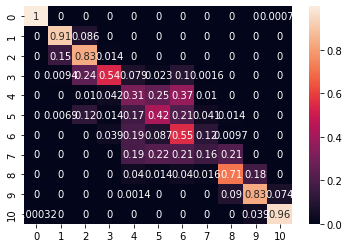

In [30]:
print('Test')
model, medidas=eval_model(modelo_elegido,train,test)

In [13]:
test['next_pheno'].value_counts()

0.0     10210
10.0     3116
9.0      1448
3.0      1272
1.0       638
2.0       555
8.0       428
7.0       247
4.0       191
5.0       145
6.0       103
Name: next_pheno, dtype: int64

In [14]:
recalls=[]
f1s=[]
precissions=[]

In [15]:
import json
import pickle

dic_info={'type':'GB','measures':medidas}
with open(pathModelos+'piral_info.json', 'w') as fp:
    json.dump(dic_info, fp)

# open a file, where you ant to store the data
file = open(path_to_models+'piral.pkl', 'wb')

# dump information to that file
pickle.dump(model, file)

# close the file
file.close()

PermissionError: [Errno 13] Permission denied: '/data/proyectos/GRAPEVINE/Models/best_models/diseases/piral_info.json'

In [16]:
import seaborn as sns
def plot_feature_importance(importance,names,model_type):

    #Create arrays from feature importance and feature names
    feature_importance = np.array(importance)
    feature_names = np.array(names)

    #Create a DataFrame using a Dictionary
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)

    #Sort the DataFrame in order decreasing feature importance
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)
    fi_df=fi_df.iloc[:20]
    #Define size of bar plot
    plt.figure(figsize=(10,8))
    #Plot Searborn bar chart
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
    #Add chart labels
    plt.title(model_type + ' FEATURE IMPORTANCE')
    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES') 

In [17]:
medidas

['phenologystageid',
 'dia',
 'min',
 'max',
 'mean',
 'std',
 'median',
 'diff',
 'variedad_CABERNET SAUVIGNON',
 'variedad_CHARDONNAY',
 'variedad_GARNACHA',
 'variedad_MAZUELA',
 'variedad_SYRACH',
 'variedad_TEMPRANILLO',
 'do_Borja',
 'do_Calatayud',
 'do_Cariñena',
 'do_Somontano',
 'latitude',
 'altitud',
 'precip__1__Cumm',
 'precip__1__Cumm 1_semanas_atras',
 'chillingDD_7.0_1_Tbase_sum_Cumm',
 'chillingDD_7.0_1_Tbase_sum_Cumm 1_semanas_atras',
 'winkler_4.5_1_TbaseMax_Cumm',
 'winkler_4.5_1_TbaseMax_Cumm 1_semanas_atras',
 'next_pheno']

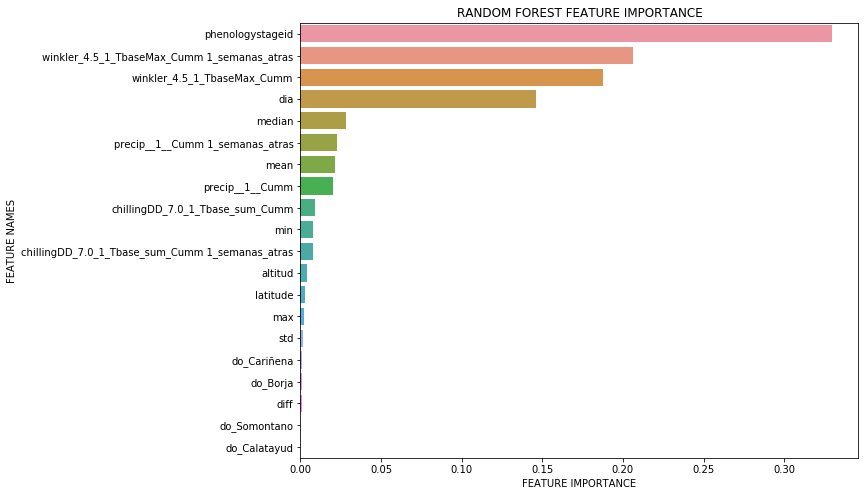

In [18]:
plot_feature_importance(model.feature_importances_,medidas[:-1],'RANDOM FOREST')

In [ ]:
modelos_estado.iloc[:1000][['params_Altitud','params_Latitud', 'params_Longitud']].sum().plot(kind='bar')

In [ ]:
modelos_estado.iloc[:1000][['params_Acumuladas', 'params_Acumulativo', 'params_Chilling']].sum().plot(kind='bar')

In [ ]:
modelos_estado.iloc[:1000][['params_Precipitaciones', 'params_Radiacion', 'params_Radiacion_max',
       'params_Radiacion_media', 'params_Radiacion_min', 'params_Tbase','params_Temperatura','params_Temperatura_max',
       'params_Temperatura_media', 'params_Temperatura_min', 'params_Viento',
       'params_Viento_este', 'params_Viento_noreste', 'params_Viento_noroeste',
       'params_Viento_norte', 'params_Viento_oeste', 'params_Viento_sur',
       'params_Viento_sureste', 'params_Viento_suroeste', 'params_Winkler',
       'params_gdd']].sum().plot(kind='bar')

In [ ]:
modelos_estado.iloc[:1000][['params_Neuronas capa 0', 'params_Neuronas capa 1',
       'params_Neuronas capa 2', 'params_Neuronas capa 3',
       'params_Neuronas capa 4', 'params_Neuronas capa 5',
       'params_Neuronas capa 6', 'params_Neuronas capa 7',
       'params_Neuronas capa 8', 'params_Neuronas capa 9']].mean().plot(kind='bar')

In [ ]:
modelos_estado.iloc[:1000][['params_2_semanas_atras','params_1_semanas_atras','params_1_semanas_adelante']].sum().plot(kind='bar')

In [ ]:
modelos_estado.iloc[:1000][['params_13_dias_atras','params_12_dias_atras','params_11_dias_atras','params_10_dias_atras',
                            'params_9_dias_atras','params_8_dias_atras','params_7_dias_atras','params_6_dias_atras',
                            'params_5_dias_atras','params_4_dias_atras','params_3_dias_atras','params_2_dias_atras',
                            'params_1_dias_atras','params_1_dias_adelante', 'params_2_dias_adelante',
                            'params_3_dias_adelante','params_4_dias_adelante','params_5_dias_adelante',
                            'params_6_dias_adelante']].sum().plot(kind='bar')

In [ ]:
modelo_elegido.to_csv('/data/proyectos/GRAPEVINE/Models/best_models/diseases/Oidio.csv')
nombre='/data/proyectos/GRAPEVINE/Models/best_models/diseases/Oidio'
     
model_json = model.to_json()
with open(nombre+".json", "w") as json_file:
    json_file.write(model_json)
model.save_weights(nombre+".h5")

In [ ]:
modelos_estado